In [2]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=f85612e99d390fee437742c572c6775a12635757f6d21584f24f7b67b687d7c4
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [4]:
import os
import cv2
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from shutil import copyfile
from os import listdir
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [5]:
print(len(os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no')))
print(len(os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes')))

98
155


In [6]:
n = len(os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'))
y = len(os.listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'))
t = (y+n)
y_prec = (y*100.0)/t
n_prec = (n*100.0)/t
print(f"Number of examples: {t}")
print(f"Percentage of positive examples: {y_prec}%, number of pos examples: {y}") 
print(f"Percentage of negative examples: {n_prec}%, number of neg examples: {n}") 

Number of examples: 253
Percentage of positive examples: 61.26482213438735%, number of pos examples: 155
Percentage of negative examples: 38.73517786561265%, number of neg examples: 98


In [7]:
os.mkdir('/kaggle/working/augmented data1')
os.mkdir('/kaggle/working/augmented data1/yesreal')
os.mkdir('/kaggle/working/augmented data1/noreal')

In [8]:
for filename in listdir('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'):
        image = cv2.imread('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes' + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        print(filename[:-4])
        break

Y115


In [9]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=1
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [10]:
augmented_data_path = '/kaggle/working/augmented data1/'

augment_data(file_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes', n_generated_samples=6, save_to_dir=augmented_data_path+'yesreal')
augment_data(file_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection/no', n_generated_samples=9, save_to_dir=augmented_data_path+'noreal')

In [11]:
print(len(os.listdir('/kaggle/working/augmented data1/noreal')))
print(len(os.listdir('/kaggle/working/augmented data1/yesreal')))

881
930


In [11]:
n = len(os.listdir('/kaggle/working/augmented data1/noreal'))
y = len(os.listdir('/kaggle/working/augmented data1/yesreal'))
t = (y+n)
y_prec = (y*100.0)/t
n_prec = (n*100.0)/t
print(f"Number of examples: {t}")
print(f"Percentage of positive examples: {y_prec}%, number of pos examples: {y}") 
print(f"Percentage of negative examples: {n_prec}%, number of neg examples: {n}") 

Number of examples: 1812
Percentage of positive examples: 51.324503311258276%, number of pos examples: 930
Percentage of negative examples: 48.675496688741724%, number of neg examples: 882


In [12]:
def crop_brain_contour(image, plot=False):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [28]:
for i in os.listdir('/kaggle/working/augmented data1/yesreal/'):
    print(i)

aug_Y257_0_4027.jpg
aug_Y91_0_8562.jpg
aug_Y62_0_7793.jpg
aug_Y46_0_2944.jpg
aug_Y10_0_9620.jpg
aug_Y245_0_4436.jpg
aug_Y249_0_4371.jpg
aug_Y14_0_2937.jpg
aug_Y155_0_2898.jpg
aug_Y166_0_6369.jpg
aug_Y169_0_3869.jpg
aug_Y3_0_5956.jpg
aug_Y95_0_1586.jpg
aug_Y3_0_8885.jpg
aug_Y27_0_4285.jpg
aug_Y182_0_8534.jpg
aug_Y186_0_1953.jpg
aug_Y29_0_4978.jpg
aug_Y26_0_8722.jpg
aug_Y181_0_9427.jpg
aug_Y66_0_8197.jpg
aug_Y65_0_7213.jpg
aug_Y243_0_2439.jpg
aug_Y20_0_9162.jpg
aug_Y114_0_4976.jpg
aug_Y163_0_901.jpg
aug_Y161_0_9003.jpg
aug_Y160_0_7070.jpg
aug_Y24_0_8543.jpg
aug_Y29_0_8469.jpg
aug_Y156_0_4782.jpg
aug_Y148_0_7203.jpg
aug_Y187_0_3523.jpg
aug_Y1_0_2903.jpg
aug_Y28_0_9685.jpg
aug_Y34_0_6841.jpg
aug_Y17_0_4717.jpg
aug_Y188_0_2487.jpg
aug_Y44_0_1978.jpg
aug_Y77_0_6814.jpg
aug_Y117_0_4613.jpg
aug_Y27_0_3725.jpg
aug_Y153_0_8808.jpg
aug_Y183_0_3946.jpg
aug_Y49_0_8376.jpg
aug_Y120_0_4943.jpg
aug_Y248_0_3993.jpg
aug_Y253_0_5180.jpg
aug_Y79_0_4562.jpg
aug_Y160_0_1304.jpg
aug_Y181_0_1176.jpg
aug_Y53_0

IndexError: index 2 is out of bounds for axis 0 with size 2

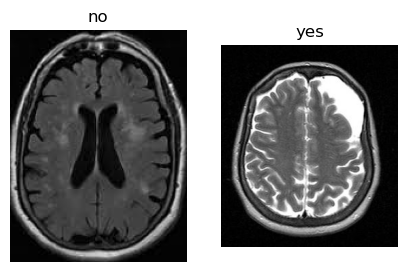

In [13]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
path_train = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/'
for count, ele in enumerate(os.listdir(path_train)):
    for j in os.listdir(path_train+ele):
        img= cv2.imread(path_train+ele+'/'+j)
        ax[count].imshow(img)
        ax[count].set_title(ele)
        ax[count].axis('off')
        break

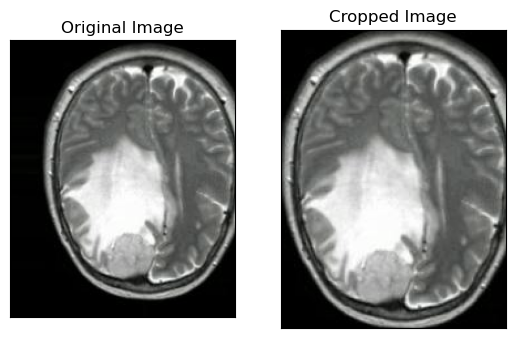

In [17]:
ex_img = cv2.imread('/kaggle/working/augmented data1/yesreal/aug_Y36_0_8533.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [18]:
X = []
y = []
image_width, image_height = (240, 240)

for directory in ['/kaggle/working/augmented data1/yesreal', '/kaggle/working/augmented data1/noreal']:
    for filename in listdir(directory):
        image = cv2.imread(directory+'/'+filename)
        image = crop_brain_contour(image, plot=False)
        image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
        image = image / 255.
        X.append(image)
        if directory[-7:-4] == 'yes':
            y.append([1])
        else:
            y.append([0])
            
X = np.array(X)
y = np.array(y)

# Shuffle the data
X, y = shuffle(X, y)

print(f'Number of examples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')

Number of examples is: 1812
X shape is: (1812, 240, 240, 3)
y shape is: (1812, 1)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1449
number of test examples = 363


In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(240, 240, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [23]:
model.fit(x=X_train, y=y_train, batch_size=3, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
483/483 [==============================] - 17s 12ms/step - loss: 0.6506 - acc: 0.6432 - val_loss: 0.5265 - val_acc: 0.7631
Epoch 2/10
483/483 [==============================] - 5s 11ms/step - loss: 0.4446 - acc: 0.8081 - val_loss: 0.4069 - val_acc: 0.8292
Epoch 3/10
483/483 [==============================] - 5s 10ms/step - loss: 0.3170 - acc: 0.8682 - val_loss: 0.4677 - val_acc: 0.8237
Epoch 4/10
483/483 [==============================] - 5s 11ms/step - loss: 0.1888 - acc: 0.9241 - val_loss: 0.4516 - val_acc: 0.8347
Epoch 5/10
483/483 [==============================] - 5s 11ms/step - loss: 0.0845 - acc: 0.9717 - val_loss: 0.5091 - val_acc: 0.8402
Epoch 6/10
483/483 [==============================] - 6s 12ms/step - loss: 0.0561 - acc: 0.9807 - val_loss: 0.4472 - val_acc: 0.8898
Epoch 7/10
483/483 [==============================] - 5s 10ms/step - loss: 0.0427 - acc: 0.9821 - val_loss: 0.4882 - val_acc: 0.8733
Epoch 8/10
483/483 [==============================] - 5s 10ms/step -

In [24]:
history = model.history.history
print(history)

{'loss': [0.6505557894706726, 0.44460201263427734, 0.3169671595096588, 0.1887603998184204, 0.08454130589962006, 0.056051481515169144, 0.042724497616291046, 0.016025802120566368, 0.02322332374751568, 0.04625626653432846], 'acc': [0.6432021856307983, 0.8081435561180115, 0.8681849837303162, 0.9240855574607849, 0.9717046022415161, 0.9806763529777527, 0.9820566177368164, 0.9958592057228088, 0.9896480441093445, 0.9841269850730896], 'val_loss': [0.526462972164154, 0.4069210886955261, 0.4677398204803467, 0.45155394077301025, 0.5091385841369629, 0.4471779465675354, 0.4882369935512543, 0.6662768721580505, 0.5065400004386902, 0.5121365189552307], 'val_acc': [0.7630854249000549, 0.8292011022567749, 0.8236914873123169, 0.8347107172012329, 0.8402203917503357, 0.8898071646690369, 0.8732782602310181, 0.8705233931541443, 0.8677685856819153, 0.8732782602310181]}


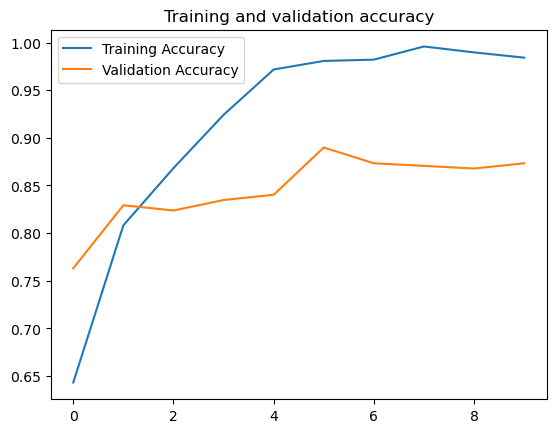

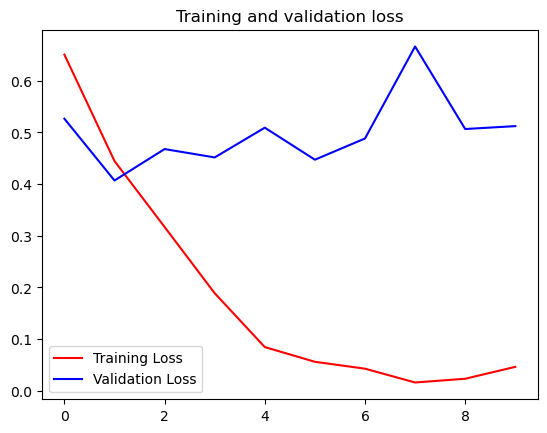

In [25]:
acc=history['acc']
val_acc=history['val_acc']
loss=history['loss']
val_loss=history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.figure()
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(loss, 'r', label="Training Loss")
plt.plot(val_loss, 'b', label="Validation Loss")
plt.legend()
plt.title('Training and validation loss')
plt.show()

In [32]:
score = model.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8732782602310181


In [26]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(240, 240, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [27]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 119, 119, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 119, 119, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           (None, 117, 117, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                      

In [28]:
model2.fit(x=X_train, y=y_train, batch_size=3, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
483/483 [==============================] - 8s 13ms/step - loss: 3.3947 - acc: 0.6977 - val_loss: 0.6076 - val_acc: 0.6970
Epoch 2/10
483/483 [==============================] - 5s 11ms/step - loss: 0.4030 - acc: 0.8544 - val_loss: 0.5527 - val_acc: 0.8182
Epoch 3/10
483/483 [==============================] - 6s 12ms/step - loss: 0.3314 - acc: 0.8992 - val_loss: 0.7653 - val_acc: 0.8154
Epoch 4/10
483/483 [==============================] - 6s 12ms/step - loss: 0.2542 - acc: 0.9137 - val_loss: 0.6192 - val_acc: 0.8540
Epoch 5/10
483/483 [==============================] - 5s 10ms/step - loss: 0.2236 - acc: 0.9248 - val_loss: 0.5843 - val_acc: 0.8512
Epoch 6/10
483/483 [==============================] - 5s 11ms/step - loss: 0.2266 - acc: 0.9372 - val_loss: 1.1372 - val_acc: 0.8017
Epoch 7/10
483/483 [==============================] - 5s 10ms/step - loss: 0.4915 - acc: 0.8841 - val_loss: 0.6163 - val_acc: 0.8567
Epoch 8/10
483/483 [==============================] - 5s 10ms/step - 

In [29]:
history2 = model2.history.history
print(history2)

{'loss': [3.394686698913574, 0.40303999185562134, 0.33140167593955994, 0.2541548013687134, 0.22362561523914337, 0.22660574316978455, 0.4914548993110657, 0.18630124628543854, 0.31851187348365784, 0.38596251606941223], 'acc': [0.6977225542068481, 0.854382336139679, 0.8992408514022827, 0.9137336015701294, 0.9247757196426392, 0.9371980428695679, 0.8840579986572266, 0.941338837146759, 0.9351276755332947, 0.9275362491607666], 'val_loss': [0.6075682640075684, 0.5527257323265076, 0.765335202217102, 0.6192161440849304, 0.5842552781105042, 1.1372331380844116, 0.6162559986114502, 0.7344004511833191, 0.5895137190818787, 0.599968671798706], 'val_acc': [0.6969696879386902, 0.8181818127632141, 0.8154270052909851, 0.8539944887161255, 0.8512396812438965, 0.8016529083251953, 0.8567492961883545, 0.8787878751754761, 0.8732782602310181, 0.9035812616348267]}


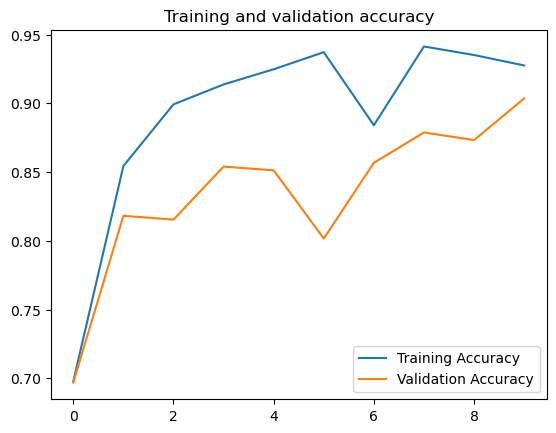

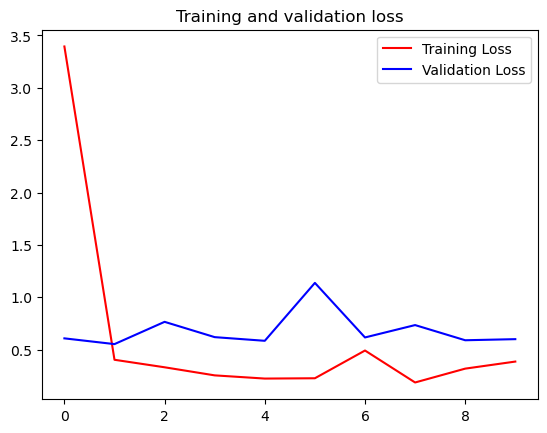

In [30]:
acc2=history2['acc']
val_acc2=history2['val_acc']
loss2=history2['loss']
val_loss2=history2['val_loss']

epochs=range(len(acc2)) # Get number of epochs

plt.figure()
plt.plot(acc2, label="Training Accuracy")
plt.plot(val_acc2, label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(loss2, 'r', label="Training Loss")
plt.plot(val_loss2, 'b', label="Validation Loss")
plt.legend()
plt.title('Training and validation loss')
plt.show()

In [31]:
score2 = model2.evaluate(X_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score2[1])


 Test accuracy: 0.9035812616348267


12/12 [==============================] - 0s 18ms/step


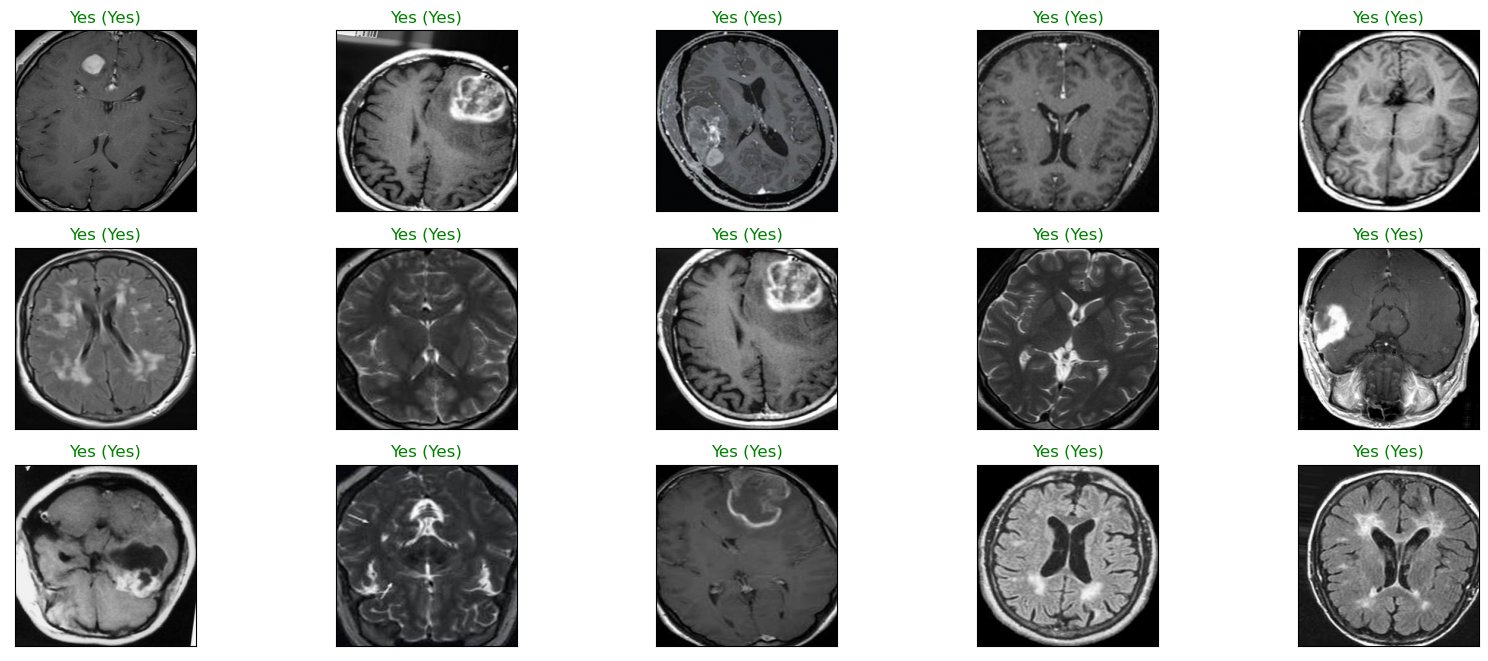

In [56]:
labels =["Yes","No",]
y_hat = model2.predict(X_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()

In [60]:
np.argmax(y_hat[1])

0

In [61]:
model2.save('brain_tumor_detection.h5')

In [62]:
import pickle
pickle.dump(model2, open('model2.pkl', 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......flatten
.........vars
......max_pooling2d
.........vars
......max_pooling2d_1
.........vars
......max_pooling2d_2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.